In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm.notebook import tqdm
import random
import gym

import torch.nn as nn
import torch.nn.functional as F


import torchvision.transforms as T



# set device
# test gpu working 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3080


In [151]:
#!pip install gym 
#!pip install ale-py 
#!pip install gym[atari,accept-rom-license]==0.21.0

In [152]:
# ALE/Breakout-v5
# Breakout-v4 
# BreakoutDeterministic-v4
enviroment = gym.make("BreakoutDeterministic-v4", render_mode="rgb_array")

In [153]:
enviroment.reset()
terminated = False
last_img = None
while not terminated:
    enviroment.render()
    action = enviroment.action_space.sample()
    observation, reward, terminated, truncated, info = enviroment.step(action)
    last_img = observation
    if terminated or truncated:
        enviroment.reset()
    
enviroment.reset()
#enviroment.close()
    

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 5, 'episode_frame_number': 0, 'frame_number': 509})

In [154]:
enviroment.close()

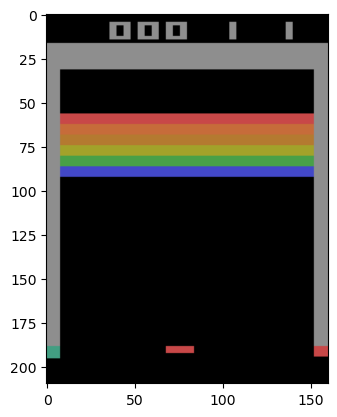

In [155]:
plt.imshow(last_img)
plt.show()

### Preprocess
84x84x1 as used in paper 
https://arxiv.org/pdf/1312.5602.pdf 

4.1 Preprocessing and Model Architecture

The raw frames are preprocessed by first converting their RGB representation
to gray-scale and down-sampling it to a 110×84 image.

The final input representation is obtained by
cropping an 84 × 84 region of the image that roughly captures the playing area

 note: tensor has channel as first dimension

In [156]:
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, Resize
# No samples for calculate mean std for normalisaiton - skip
class Preprocess():
    def __init__(self, target_width = 84, target_height = 84):
        self.width = target_width
        self.height = target_height
        
        # transform
        self.transform = T.Compose([
            ToTensor(),
            Grayscale(),
            Resize((110,84))
        ])
    
    def process(self,image):
        #return self.transform(image)
        # crop to play area not clear from paper exactly which area is considered
        # tested different values
        return T.functional.crop(self.transform(image),18,0,self.height,self.width)

$\phi$ function stacks 4 images to create a state

In [157]:
test = Preprocess()
proc_img = test.process(last_img)
print(proc_img.shape)

torch.Size([1, 84, 84])


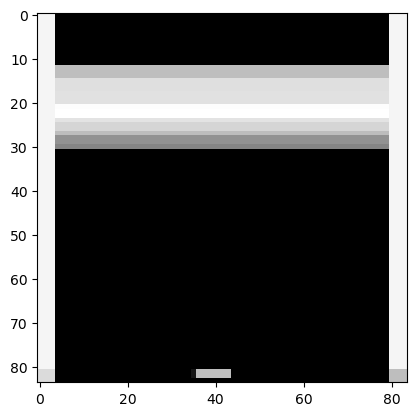

In [158]:
plt.imshow(proc_img.permute(1, 2, 0),cmap='gray')

### Architecture
Based on https://www.nature.com/articles/nature14236

The input to the neural network consists of an 84x84x4 image produced by the preprocessing map w. 

The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. 

The second hidden layer convolves 64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.

This is followed by a third convolutional layer that convolves 64filters of 3x3 with
stride 1 followed by a rectifier. 

The final hidden layer is fully-connected and consists of 512 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action. 

##### We have 4 valid actions!

In [159]:
class DeepQ(nn.Module):
    # TODO clean up
    # TODO handle reward etc
    def __init__(self, state_shape, nr_actions = 4):
        super().__init__()
        self.frames_state = state_shape[0]
        self.nr_actions = nr_actions
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.frames_state, out_channels = 32, kernel_size = (8,8), stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, (4,4), 2),
            nn.ReLU(),
            nn.Conv2d(64,64,(3,3),1),
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Linear(64*7*7,512),
            nn.ReLU(),
            nn.Linear(512,self.nr_actions)
        )
        
    def forward(self,state):
        state = self.conv(state)
        state = state.flatten()
        state = self.linear(state)
        return state
        

# Memory
We don't want to just learn from the previous states actiosn since they are highly correlated and the network would "forget" old states actions 
So we sample a batch from this memory

## notes from nature paper
**memory of 1 million most recent frames**

First, we use a technique known as experience replay in which we store the
agent’s experiences at each time-step, $e_t = (s_t, a_t,r_t,s_{t+1})$, in a data set $D_t = \{e_1,…,e_t\}$,
pooled over many episodes (where the end of an episode occurs when a terminal state is reached) into a replay memory. 

##### Details
During the inner loop of the algorithm,
we apply Q-learning updates, or minibatch updates, to samples of experience,
$(s, a,r,s^{'}) \sim U(D)$, drawn at random from the pool of stored samples. This approach
has several advantages over standard online Q-learning. First, each step of experience
is potentially used in many weight updates, which allowsfor greater data efficiency.

Second, learning directly from consecutive samples is inefficient, owing to the strong
correlations between the samples; randomizing the samples breaks these correlations and therefore reduces the variance of the updates. Third, when learning onpolicy the current parameters determine the next data sample that the parameters
are trained on. For example, if the maximizing action is to move left then the training samples will be dominated by samples from the left-hand side; if the maximizing action then switches to the right then the training distribution will also switch.
Itis easy to see how unwanted feedback loops may arise and the parameters could get
stuckin a poor localminimum, or even diverge catastrophically. By using experience replay the behaviour distribution is averaged over many of its previous states,
smoothing out learning and avoiding oscillations or divergence in the parameters.
Note that when learning by experience replay, it is necessary to learn off-policy
(because our current parameters are different to those used to generate the sample), which motivates the choice of Q-learning.


In practice, our algorithm only stores the last $N$ experience tuples in the replay
memory, and samples uniformly at random from $D$ when performing updates. This
approach is in some respects limited because the memory buffer does not differentiate important transitions and always overwrites with recent transitions owing
to the finite memory size $N$. Similarly, the uniform sampling gives equal importance to all transitions in the replay memory. A more sophisticated sampling strategy might emphasize transitions from which we can learn the most, similar to
prioritized sweeping.



#### Tips
Store frames in unit8 to save memory 

state t and state t+1 share 3 frames

In [216]:
# Question - Should this be stored on the gpu or cpu ? 
# I'll try and store on cpu to save on vram
class Replay():
    # 1 million frames might be too much for our memory pool
    def __init__(self,batch_size = 32 , capacity = 1000000):
        self.batch_size = batch_size 
        self.capacity = capacity
        
        # keep track where to store next experience
        self.experience = 0
        # experiences in memory
        self.memory_used = 0
        
        # Question - store in list or as arrays with allocated memory?
        # Guess arrays and allocation
        
        # allocate memory for frames
        self.frame_memory = torch.empty(size = (self.capacity, 84,84) ,dtype = torch.uint8)
        # allocate associated actions - Question - what type? 
        self.action_memory = torch.empty(size = (self.capacity,1), dtype = torch.int)
        # store associated rewards 
        self.reward_memory = torch.empty(size = (self.capacity,1), dtype = torch.float)
        
        
    # e_t = (s_t, a_t,r_t,s_{t+1})
    # store frames instead and then when sampling combine consectuive frames to create state
    def update(self, frame, action,reward):
        self.action_memory[self.experience] = action
        self.reward_memory[self.experience] = reward
        
        # convert frame to unit8
        # rounding errors, so we need to undo our scaling during preprocess 
        # feels inefficient 
        # TODO - maybe change preprocess so this is not necessary
        self.frame_memory[self.experience] = (frame*255).type(torch.uint8)
        
        
        self.memory_used = max(self.experience+1,  self.memory_used )
        self.experience = (self.experience + 1) % self.capacity
        
        
        
        
    # selection random uniformly
    # Should return (s_t, a_t,r_t,s_{t+1})
    
    # dimension (batch_size, (4,width,height), 4, 4 , (4,width,height)
    def sample_batch(self):
        # TODO current_memory_size
        # we need previus state so start at 3 
        sample_indexes = np.random.randint(3,self.memory_used-1, self.batch_size)
        print(self.memory_used)
        print(sample_indexes)
        for index in sample_indexes:
            
            
        
        
    #def generate_state(self,index):
        #self.frame_memory
        
        
        
    

In [225]:
buffer =  Replay()

In [230]:
buffer.update(proc_img, 1, 1)

In [231]:
buffer.sample_batch()

5
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


Q

In [ ]:
class Qvalue():
    
    # for action network
    def q_action(model, states, actions):
        model(states)
    
    # next state using target network
    def 
    


#### Algorithm 1: deep Q-learning with experience replay 
source: https://www.nature.com/articles/nature14236/


#### dummy implement
stupid tests 

In [ ]:
#TODO structure it 

# TODO batches
state = np.array([[1]]) # just for shape for now

M = 2
T = 5
preprocessor = Preprocess()
# TODO initial replay memory D to Capacity N
action_Q = DeepQ(state.shape) # init action network Random weights
target_Q = DeepQ(state.shape) # init target network, TODO same weights as action
for episode in range(M): # - for episode = 1, M do:
    # intialize state - initilize sequence s1={x1} and preprocess sequence 
    env = gym.make("BreakoutDeterministic-v4")
    frame, info = env.reset()
    frame = preprocessor.process(frame)
    state = torch.cat((frame,frame,frame,frame))
    
    for t in range(T): # - for t=1, T do:
        # TODO
        # selection action with prob e
        # otherwise select action a = argmax(Q(state),a; weights)
        #  action = 
        
        # TODO 
        # Execute action a and observe reward r and next image
        #new_obs, reward, _, _, _ = env.step(action)
        
        
        # TODO
        #set s_t+1 = s_t,a_t,x_t+1 and preprocess_t+1 = pre(s_t+1)
        # new_obs = preprocessor.process(new_obs)
        
        #next_state   
        # should remove first frame and add new frame last 
        #new_state = np.append(state[1: , :, :], new_obs, axis=0)
        
        
        # TODO
        # store transition pre_t,a_t,r_t,pre_t+1 in D 
        # replay shit
        
        #TODO 
        # sample random minibatch of transitions pre_t,a_t,r_t,pre_t+1 from D 
        # This should probabiliy be its own function 
        # if episode terminate at next step
        # set y_j = r_j + gamma max(Q) -- etc 
        # oteherwise gradient descent 
        
        # at every step update target network weights to action network weights
        
        
    
        

        
        
        
    

In [ ]:
plt.imshow(proc_img.permute(1, 2, 0)*255,cmap='gray')

#### Random test area

In [234]:
print(test.forward(proc_img).shape)


torch.Size([4])


In [ ]:
frame_memory = torch.empty(size = (4, 2,2) ,dtype = torch.uint8)

In [ ]:
frame_memory

In [ ]:
new_test = np.array([[1,3],[4,5]])
new_test = torch.tensor(new_test)
new_test

In [ ]:
frame_memory[3] = new_test+3

In [ ]:
frame_memory

In [ ]:
frame_memory[0,...]

In [ ]:
torch.tensor(np.array([1,2,3]))

In [ ]:
test = torch.empty(size = (5,1))

In [ ]:
test.shape
test[1] = 1

In [ ]:
test

In [ ]:
last_img.shape

In [243]:
env = gym.make("BreakoutDeterministic-v4").unwrapped

In [248]:
env.render(human)

NameError: name 'human' is not defined

In [274]:
t.render()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [277]:
env

In [279]:
env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [25]:
from torch.utils.tensorboard import SummaryWriter 
env = gym.make("BreakoutDeterministic-v4", render_mode="rgb_array")
env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [26]:
test_a = env.action_space.sample()
observation, reward, done, info  = env.step(test_a)


In [33]:
(info["rgb"] == observation).all()

True

In [309]:
import torch.optim as optim
optimizer = optim.Adam(params=policy_net.parameters(), lr=0.00005)
criterion = torch.nn.SmoothL1Loss()
tracker_dict = init_tracker_dict()

In [310]:
import time
plt.figure()
# for estimating the time
t1,t2 = time.time(),time.time()
num_target_update = 0

<Figure size 640x480 with 0 Axes>